# FROZEN PRODUCT AMOUNT FORECAST BY TIME

## Data

Info about this data set: https://fred.stlouisfed.org/series/IPN31152N


Units:  Index 2012=100, Not Seasonally Adjusted

Frequency:  Monthly

The industrial production (IP) index measures the real output of all relevant establishments located in the United States, regardless of their ownership, but not those located in U.S. territories.

NAICS = 31152

Source Code: IP.N31152.N

Suggested Citation:
Board of Governors of the Federal Reserve System (US), Industrial Production: Nondurable Goods: Ice cream and frozen dessert [IPN31152N], retrieved from FRED, Federal Reserve Bank of St. Louis; https://fred.stlouisfed.org/series/IPN31152N, November 16, 2019.

# 1. Libraries|User Defined Functions

## 1.1. Import Libraries

In [1]:
# !pip install pyforest
# 1-Import Libraies
import numpy as np
import pandas as pd 
import seaborn as sns
import matplotlib.pyplot as plt
import scipy.stats as stats
%matplotlib inline
import statsmodels.api as sm
import statsmodels.formula.api as smf
import missingno as msno 

from sklearn.compose import make_column_transformer

# Scaling
from sklearn.preprocessing import scale 
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import PolynomialFeatures 
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import PowerTransformer 
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import RobustScaler


# Importing plotly and cufflinks in offline mode
import cufflinks as cf
import plotly.offline
cf.go_offline()
cf.set_config_file(offline=False, world_readable=True)

# Ignore Warnings
import warnings
warnings.filterwarnings("ignore")
warnings.warn("this will not show")

# Figure&Display options
plt.rcParams["figure.figsize"] = (10,6)
pd.set_option('max_colwidth',200)
pd.set_option('display.max_rows', 1000)
pd.set_option('display.max_columns', 200)
pd.set_option('display.float_format', lambda x: '%.3f' % x)

# !pip install termcolor
import colorama
from colorama import Fore, Style  # maakes strings colored
from termcolor import colored

import ipywidgets
from ipywidgets import interact

## 1.2. Some Useful User Defined Functions

In [2]:
## Some Useful Functions

###############################################################################

def missing_values(df):
    missing_number = df.isnull().sum().sort_values(ascending=False)
    missing_percent = (df.isnull().sum()/df.isnull().count()).sort_values(ascending=False)
    missing_values = pd.concat([missing_number, missing_percent], axis=1, keys=['Missing_Number', 'Missing_Percent'])
    return missing_values[missing_values['Missing_Number']>0]

###############################################################################

def first_looking(df):
    print(colored("Shape:", attrs=['bold']), df.shape,'\n', 
          colored('-'*79, 'red', attrs=['bold']),
          colored("\nInfo:\n", attrs=['bold']), sep='')
    print(df.info(), '\n', 
          colored('-'*79, 'red', attrs=['bold']), sep='')
    print(colored("Number of Uniques:\n", attrs=['bold']), df.nunique(),'\n',
          colored('-'*79, 'red', attrs=['bold']), sep='')
    print(colored("Missing Values:\n", attrs=['bold']), missing_values(df),'\n', 
          colored('-'*79, 'red', attrs=['bold']), sep='')
    print(colored("All Columns:", attrs=['bold']), list(df.columns),'\n', 
          colored('-'*79, 'red', attrs=['bold']), sep='')

    df.columns= df.columns.str.lower().str.replace('&', '_').str.replace(' ', '_')

    print(colored("Columns after rename:", attrs=['bold']), list(df.columns),'\n',
              colored('-'*79, 'red', attrs=['bold']), sep='')
    
        
def multicolinearity_control(df):
    feature =[]
    collinear=[]
    for col in df.corr().columns:
        for i in df.corr().index:
            if (abs(df.corr()[col][i])> .9 and abs(df.corr()[col][i]) < 1):
                    feature.append(col)
                    collinear.append(i)
                    print(colored(f"Multicolinearity alert in between:{col} - {i}", 
                                  "red", attrs=['bold']), df.shape,'\n',
                                  colored('-'*79, 'red', attrs=['bold']), sep='')

def duplicate_values(df):
    print(colored("Duplicate check...", attrs=['bold']), sep='')
    duplicate_values = df.duplicated(subset=None, keep='first').sum()
    if duplicate_values > 0:
        df.drop_duplicates(keep='first', inplace=True)
        print(duplicate_values, colored("Duplicates were dropped!"),'\n',
              colored('-'*79, 'red', attrs=['bold']), sep='')
    else:
        print(colored("There are no duplicates"),'\n',
              colored('-'*79, 'red', attrs=['bold']), sep='')     
        
def drop_columns(df, drop_columns):
    if drop_columns !=[]:
        df.drop(drop_columns, axis=1, inplace=True)
        print(drop_columns, 'were dropped')
    else:
        print(colored('We will now check the missing values and if necessary will drop realted columns!', attrs=['bold']),'\n',
              colored('-'*79, 'red', attrs=['bold']), sep='')
        
def drop_null(df, limit):
    print('Shape:', df.shape)
    for i in df.isnull().sum().index:
        if (df.isnull().sum()[i]/df.shape[0]*100)>limit:
            print(df.isnull().sum()[i], 'percent of', i ,'null and were dropped')
            df.drop(i, axis=1, inplace=True)
            print('new shape:', df.shape)       
    print('New shape after missing value control:', df.shape)
    
###############################################################################

# 2. Read dataset

In [3]:
df0 = pd.read_csv("Frozen_Dessert_Production.csv",
                   index_col='DATE',
                   parse_dates=True)
df = df0.copy()
df.head()
first_looking(df)
duplicate_values(df)
drop_columns(df,[])
drop_null(df, 90)
# df.head()
# df.describe().T
# df.describe(include=object).T

Shape:(573, 1)
-------------------------------------------------------------------------------
Info:

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 573 entries, 1972-01-01 to 2019-09-01
Data columns (total 1 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   IPN31152N  573 non-null    float64
dtypes: float64(1)
memory usage: 9.0 KB
None
-------------------------------------------------------------------------------
Number of Uniques:
IPN31152N    573
dtype: int64
-------------------------------------------------------------------------------
Missing Values:
Empty DataFrame
Columns: [Missing_Number, Missing_Percent]
Index: []
-------------------------------------------------------------------------------
All Columns:['IPN31152N']
-------------------------------------------------------------------------------
Columns after rename:['ipn31152n']
-------------------------------------------------------------------------------
Duplicate check

In [4]:
df = df.rename(columns={'ipn31152n':'amount'})

In [5]:
df.head()

,amount
DATE,
1972-01-01,59.962
1972-02-01,67.061
1972-03-01,74.235
1972-04-01,78.112
1972-05-01,84.764


In [6]:
df.tail()

,amount
DATE,
2019-05-01,114.561
2019-06-01,124.960
2019-07-01,110.263
2019-08-01,102.609
2019-09-01,101.587


In [7]:
df.describe().T

,count,mean,std,min,25%,50%,75%,max
amount,573.000,109.896,27.951,58.660,88.936,107.643,128.278,196.174


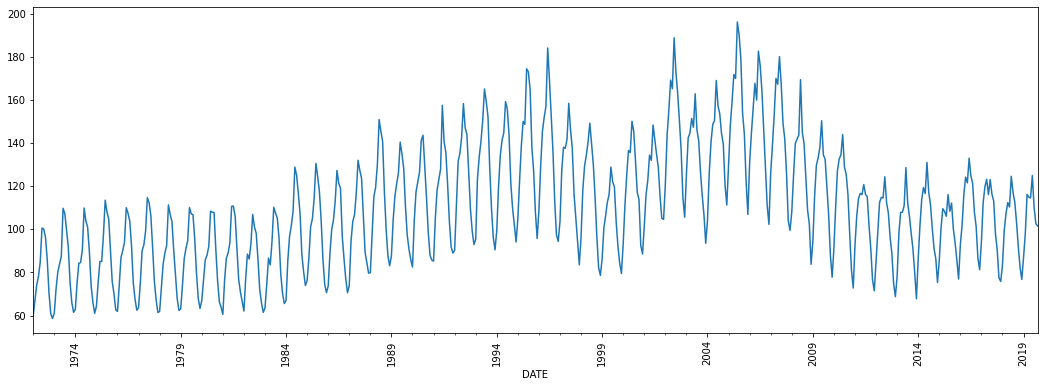

In [8]:
df['amount'].plot(figsize=(18,6))
plt.xticks(rotation=90);

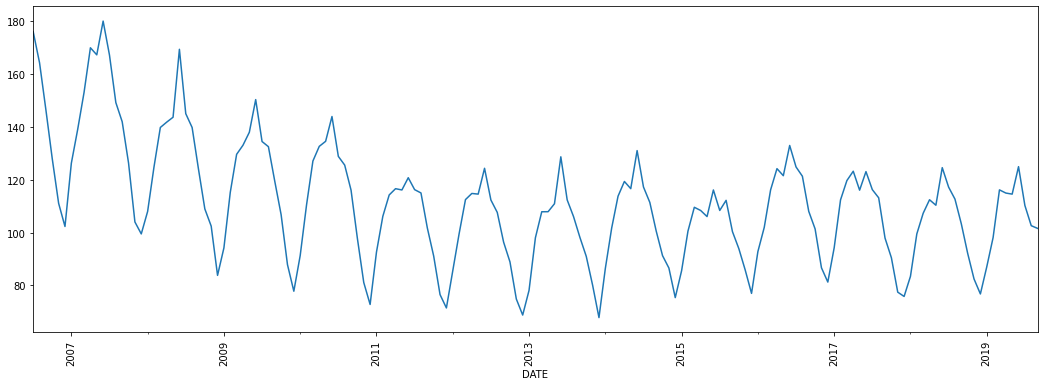

In [9]:
df['amount'].loc["2006-06-30" : "2019-09-01"].plot(figsize=(18,6))
plt.xticks(rotation=90);

### 3. Check missing values

In [10]:
missing_values(df)

,Missing_Number,Missing_Percent


### 4. Plot the distribution of various discrete features on (Season, haliday, weekend and weathercode)

In [11]:
df.head(2)

,amount
DATE,
1972-01-01,59.962
1972-02-01,67.061


In [12]:
df_ = df.copy()
df_["year"] = df_.index.year
df_['month'] = df_.index.month 
df_.head(2)

,amount,year,month
DATE,,,
1972-01-01,59.962,1972,1
1972-02-01,67.061,1972,2


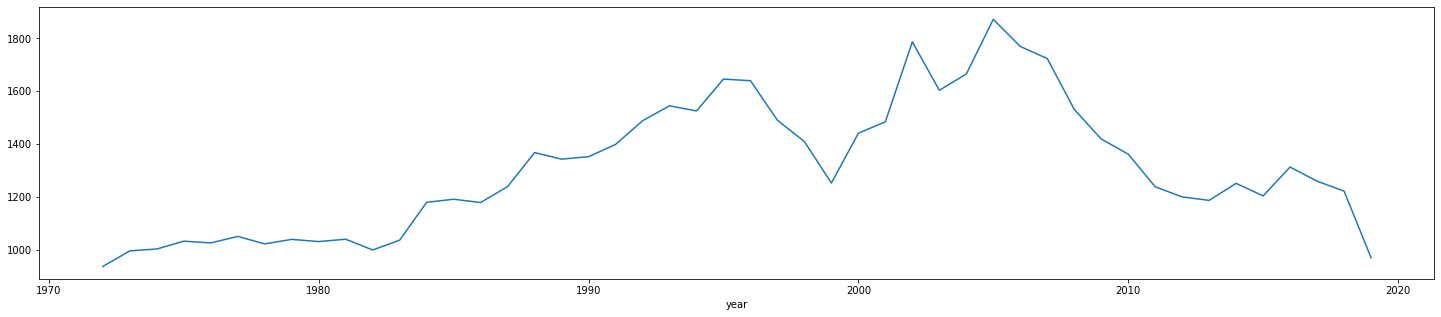

In [18]:
yearly_total_amount = df_.groupby("year")["amount"].sum()
plt.figure(figsize=(25,5))
sns.lineplot(yearly_total_amount.index, yearly_total_amount.values);

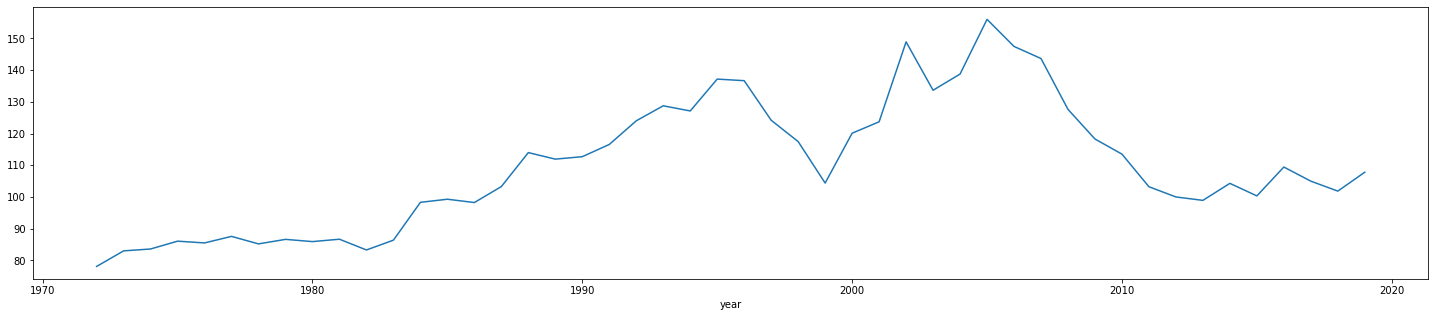

In [19]:
yearly_avg_amount = df_.groupby("year")["amount"].mean()
plt.figure(figsize=(25,5))
sns.lineplot(yearly_avg_amount.index, yearly_avg_amount.values);

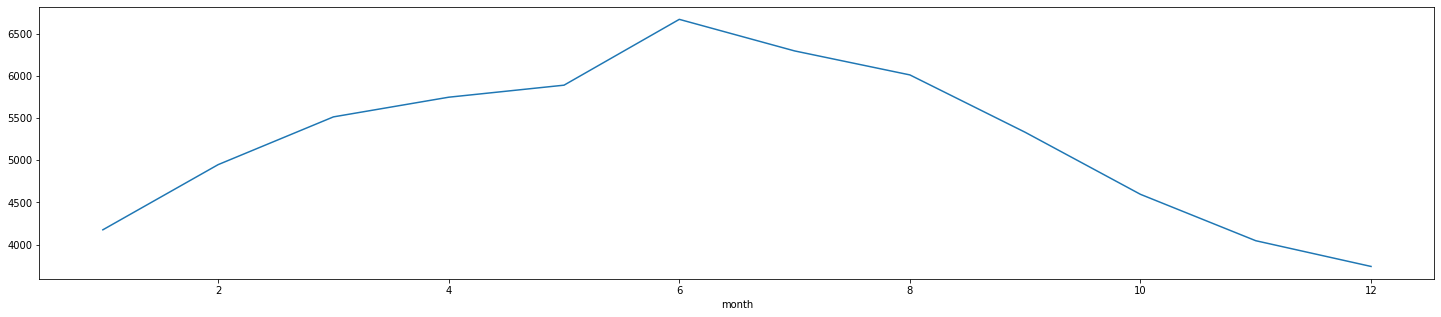

In [20]:
monthly_total_amount = df_.groupby("month")["amount"].sum()
plt.figure(figsize=(25,5))
sns.lineplot(monthly_total_amount.index, monthly_total_amount.values);

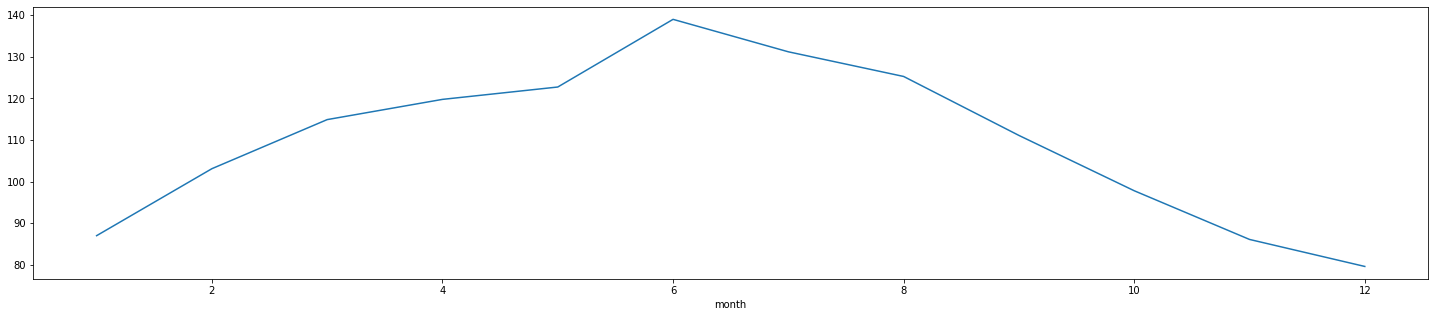

In [21]:
monthly_avg_amount = df_.groupby("month")["amount"].mean()
plt.figure(figsize=(25,5))
sns.lineplot(monthly_avg_amount.index, monthly_avg_amount.values);

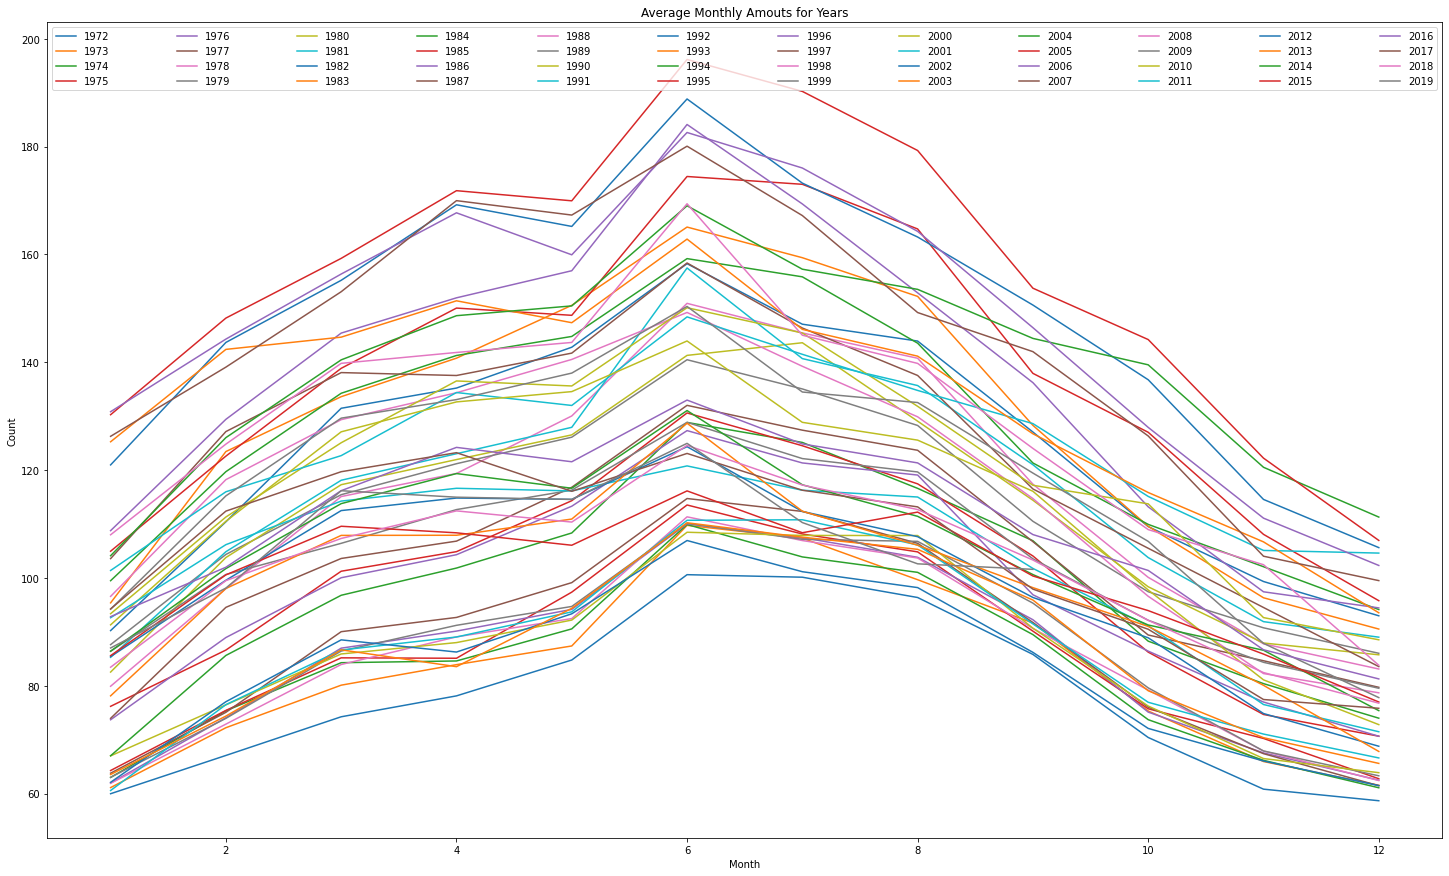

In [22]:
year_month_comp = df_.groupby(["year", "month"])["amount"].mean()

plt.figure(figsize=(25,15))
for i in year_month_comp.index.levels[0]:
    plt.plot(year_month_comp[i].index, year_month_comp[i], label=i)

plt.legend(loc='best', mode = "expand", ncol = 12)
plt.xlabel('Month')
plt.ylabel('Count')
plt.title('Average Monthly Amouts for Years')
plt.show()

### 5. Preprocessing of Data

### Train Test Split

In [23]:
len(df)

573

In [24]:
test_size = 72

In [25]:
test_ind = len(df)- test_size
test_ind 

501

In [26]:
train = df.iloc[:test_ind]
test = df.iloc[test_ind:]

In [27]:
train.head(2)

,amount
DATE,
1972-01-01,59.962
1972-02-01,67.061


In [28]:
test.head(2)

,amount
DATE,
2013-10-01,90.998
2013-11-01,80.069


### Scaling

In [29]:
from sklearn.preprocessing import StandardScaler

In [30]:
scaler = StandardScaler()

In [31]:
train_scaled = scaler.fit_transform(train)
test_scaled = scaler.transform(test)

### Time Series Generator

In [32]:
from tensorflow.keras.preprocessing.sequence import TimeseriesGenerator

In [35]:
length = 24
generator = TimeseriesGenerator(train_scaled, train_scaled, length = length, batch_size = 1)

In [36]:
generator[0]

(array([[[-1.7428696 ],
         [-1.49951581],
         [-1.25354961],
         [-1.1206329 ],
         [-0.8925935 ],
         [-0.34980513],
         [-0.36590803],
         [-0.49500557],
         [-0.85703819],
         [-1.38525269],
         [-1.71390014],
         [-1.78752029],
         [-1.70387568],
         [-1.32310376],
         [-1.05253237],
         [-0.92199836],
         [-0.80319612],
         [-0.03608809],
         [-0.11740487],
         [-0.3817881 ],
         [-0.65728601],
         [-1.21686981],
         [-1.53812919],
         [-1.68910639]]]),
 array([[-1.6394229]]))

In [37]:
train_scaled[0:25]

array([[-1.7428696 ],
       [-1.49951581],
       [-1.25354961],
       [-1.1206329 ],
       [-0.8925935 ],
       [-0.34980513],
       [-0.36590803],
       [-0.49500557],
       [-0.85703819],
       [-1.38525269],
       [-1.71390014],
       [-1.78752029],
       [-1.70387568],
       [-1.32310376],
       [-1.05253237],
       [-0.92199836],
       [-0.80319612],
       [-0.03608809],
       [-0.11740487],
       [-0.3817881 ],
       [-0.65728601],
       [-1.21686981],
       [-1.53812919],
       [-1.68910639],
       [-1.6394229 ]])

In [38]:
X, y = generator[0]

In [39]:
print(f'Given the Array: \n{X.flatten()}')
print(f'Predict this y: \n {y}')

Given the Array: 
[-1.7428696  -1.49951581 -1.25354961 -1.1206329  -0.8925935  -0.34980513
 -0.36590803 -0.49500557 -0.85703819 -1.38525269 -1.71390014 -1.78752029
 -1.70387568 -1.32310376 -1.05253237 -0.92199836 -0.80319612 -0.03608809
 -0.11740487 -0.3817881  -0.65728601 -1.21686981 -1.53812919 -1.68910639]
Predict this y: 
 [[-1.6394229]]


## 6. Modelling & Model Performance

### Creating Model

### 6.1. With "tanh" activation function

In [40]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, LSTM
from keras.layers import Dropout

In [41]:
n_features = 1

In [42]:
model = Sequential()
model.add(LSTM(56, activation = 'tanh', input_shape = (length, n_features)))
model.add(Dense(1))
model.compile(optimizer = 'adam', loss = 'mse')

In [43]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, 56)                12992     
                                                                 
 dense (Dense)               (None, 1)                 57        
                                                                 
Total params: 13,049
Trainable params: 13,049
Non-trainable params: 0
_________________________________________________________________


### EarlyStopping and Validation Generator

In [44]:
from tensorflow.keras.callbacks import EarlyStopping

In [45]:
early_stop = EarlyStopping(monitor = 'val_loss', patience = 10)

In [46]:
validation_generator = TimeseriesGenerator(test_scaled, test_scaled, length = length, batch_size = 1)

In [47]:
len(validation_generator)

48

In [48]:
model.fit_generator(generator, epochs = 64,
                    validation_data = validation_generator,
                    callbacks = [early_stop])

Epoch 1/64
477/477 [==============================] - 7s 10ms/step - loss: 0.4304 - val_loss: 0.0771
Epoch 2/64
477/477 [==============================] - 4s 9ms/step - loss: 0.0846 - val_loss: 0.0581
Epoch 3/64
477/477 [==============================] - 4s 9ms/step - loss: 0.0655 - val_loss: 0.0545
Epoch 4/64
477/477 [==============================] - 4s 9ms/step - loss: 0.0569 - val_loss: 0.0604
Epoch 5/64
477/477 [==============================] - 4s 8ms/step - loss: 0.0617 - val_loss: 0.0361
Epoch 6/64
477/477 [==============================] - 4s 9ms/step - loss: 0.0533 - val_loss: 0.0367
Epoch 7/64
477/477 [==============================] - 4s 9ms/step - loss: 0.0491 - val_loss: 0.0466
Epoch 8/64
477/477 [==============================] - 4s 9ms/step - loss: 0.0497 - val_loss: 0.0314
Epoch 9/64
477/477 [==============================] - 4s 9ms/step - loss: 0.0445 - val_loss: 0.0393
Epoch 10/64
477/477 [==============================] - 4s 9ms/step - loss: 0.0424 - val_loss: 0.042

<AxesSubplot:>

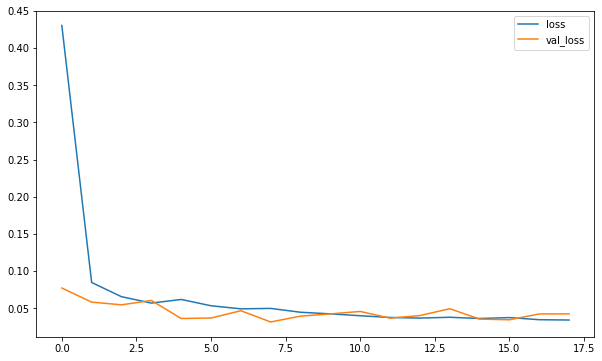

In [49]:
loss_df = pd.DataFrame(model.history.history)
loss_df.plot()

#### Evaluate on Test Data

In [50]:
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

In [51]:
def eval_metrics(actual, pred):
    rmse = np.sqrt(mean_squared_error(actual, pred))
    mae = mean_absolute_error(actual, pred)
    mse = mean_squared_error(actual, pred)
    score = r2_score(actual, pred)
    return print("r2_score:", score, "\n","mae:", mae, "\n","mse:",mse, "\n","rmse:",rmse)

In [52]:
validation_generator[0]

(array([[[-0.67885026],
         [-1.05352659],
         [-1.47405696],
         [-0.83657786],
         [-0.31090033],
         [ 0.10203626],
         [ 0.29325874],
         [ 0.1999222 ],
         [ 0.69390816],
         [ 0.22190814],
         [ 0.02120974],
         [-0.34907146],
         [-0.66982345],
         [-0.83058513],
         [-1.21446997],
         [-0.86471081],
         [-0.35110789],
         [-0.04184085],
         [-0.08357059],
         [-0.16255953],
         [ 0.18301706],
         [-0.08302549],
         [ 0.04819762],
         [-0.35829712]]]),
 array([[-0.57827993]]))

In [53]:
len(validation_generator)

48

In [54]:
validation_generator[47]

(array([[[-0.44180461],
         [-0.69684904],
         [-1.14374677],
         [-1.19949156],
         [-0.93816641],
         [-0.38772599],
         [-0.11944816],
         [ 0.05593539],
         [-0.01525408],
         [ 0.4725883 ],
         [ 0.2201734 ],
         [ 0.06440338],
         [-0.25669829],
         [-0.63997632],
         [-0.97243609],
         [-1.16695662],
         [-0.81596326],
         [-0.43497878],
         [ 0.18418613],
         [ 0.14299463],
         [ 0.12897272],
         [ 0.48549257],
         [-0.01838072],
         [-0.2808098 ]]]),
 array([[-0.315844]]))

In [55]:
y_pred = model.predict(validation_generator)
y_pred

48/48 [==============================] - 1s 3ms/step


array([[-0.73324895],
       [-0.92586726],
       [-1.064004  ],
       [-0.993232  ],
       [-0.2808873 ],
       [-0.02048988],
       [ 0.27728468],
       [ 0.71832305],
       [ 0.8542188 ],
       [ 0.57295895],
       [ 0.15531197],
       [-0.11102486],
       [-0.49321574],
       [-0.67808884],
       [-0.92754155],
       [-0.6414677 ],
       [-0.11152625],
       [ 0.17757492],
       [ 0.40956146],
       [ 0.8371134 ],
       [ 0.76051515],
       [ 0.35652792],
       [-0.0645257 ],
       [-0.33758384],
       [-0.76304305],
       [-0.9795983 ],
       [-1.1888399 ],
       [-0.8818512 ],
       [-0.50424045],
       [-0.23187847],
       [-0.04194118],
       [ 0.36410022],
       [ 0.4173206 ],
       [ 0.20509055],
       [-0.1380256 ],
       [-0.40954292],
       [-0.6885178 ],
       [-0.9838966 ],
       [-1.1255362 ],
       [-0.8854046 ],
       [-0.36193436],
       [-0.14242296],
       [ 0.1726756 ],
       [ 0.4897949 ],
       [ 0.66652113],
       [ 0

In [56]:
len(y_pred)

48

In [57]:
len(test_scaled)

72

In [58]:
len(test_scaled[24:])

48

In [59]:
test_scaled[24:]

array([[-0.57827993],
       [-0.85486805],
       [-1.15961655],
       [-0.61671847],
       [-0.30255233],
       [ 0.18444325],
       [ 0.45978345],
       [ 0.36834622],
       [ 0.76065107],
       [ 0.48175225],
       [ 0.36109871],
       [-0.09474012],
       [-0.32280353],
       [-0.82741734],
       [-1.01281507],
       [-0.56752523],
       [ 0.0544612 ],
       [ 0.30508308],
       [ 0.42610345],
       [ 0.18047323],
       [ 0.42126264],
       [ 0.18734363],
       [ 0.08133252],
       [-0.44180461],
       [-0.69684904],
       [-1.14374677],
       [-1.19949156],
       [-0.93816641],
       [-0.38772599],
       [-0.11944816],
       [ 0.05593539],
       [-0.01525408],
       [ 0.4725883 ],
       [ 0.2201734 ],
       [ 0.06440338],
       [-0.25669829],
       [-0.63997632],
       [-0.97243609],
       [-1.16695662],
       [-0.81596326],
       [-0.43497878],
       [ 0.18418613],
       [ 0.14299463],
       [ 0.12897272],
       [ 0.48549257],
       [-0

In [60]:
eval_metrics(test_scaled[24:], y_pred)

r2_score: 0.8506713046369218 
 mae: 0.1566634843804364 
 mse: 0.04232825203899485 
 rmse: 0.20573830960468897


In [61]:
test_predictions = []

first_eval_batch = train_scaled[-length:]

current_batch = first_eval_batch.reshape((1, length, n_features))

for i in range(len(test)):
    
    # get prediction 1 time stamp ahead
    current_pred = model.predict(current_batch)[0]
    
    # store prediction
    test_predictions.append(current_pred) 
    
    # update batch to now include prediction and drop first value
    current_batch = np.append(current_batch[:, 1:, :], [[current_pred]], axis=1)

1/1 [==============================] - 0s 24ms/step


In [62]:
eval_metrics(test_scaled, test_predictions)

r2_score: 0.0947331747970459 
 mae: 0.3878867046718606 
 mse: 0.2564486714904122 
 rmse: 0.5064076139735778


#### Inverse Transformations and Comparing

In [63]:
true_predictions = scaler.inverse_transform(test_predictions)

In [64]:
test.head()

,amount
DATE,
2013-10-01,90.998
2013-11-01,80.069
2013-12-01,67.803
2014-01-01,86.397
2014-02-01,101.731


In [65]:
test['prediction'] = true_predictions

In [66]:
test.head()

,amount,prediction
DATE,,
2013-10-01,90.998,85.921
2013-11-01,80.069,76.881
2013-12-01,67.803,72.961
2014-01-01,86.397,80.117
2014-02-01,101.731,92.794


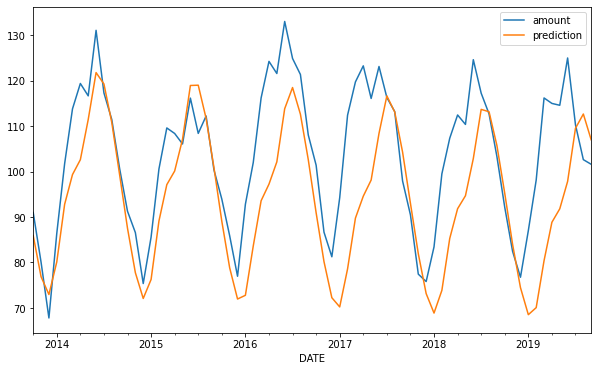

In [67]:
test.plot();

#### Calculation R2 Score and Error Metrics

In [68]:
eval_metrics(test.amount, test.prediction)

r2_score: 0.09473323591304295 
 mae: 11.31412805870904 
 mse: 218.189006361282 
 rmse: 14.771222236540956


### 6.2. With "relu" activation function

In [69]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, LSTM

n_features = 1
model = Sequential()

model.add(LSTM(56, activation = 'relu', input_shape = (length, n_features))) 
model.add(Dense(1)) 

model.compile(optimizer = 'adam', loss = 'mse')
model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_1 (LSTM)               (None, 56)                12992     
                                                                 
 dense_1 (Dense)             (None, 1)                 57        
                                                                 
Total params: 13,049
Trainable params: 13,049
Non-trainable params: 0
_________________________________________________________________


### EarlyStopping and Validation Generator

In [70]:
from tensorflow.keras.callbacks import EarlyStopping
early_stop = EarlyStopping(monitor = 'val_loss', patience = 10)
validation_generator = TimeseriesGenerator(test_scaled, test_scaled, length = length, batch_size = 1)
len(validation_generator)

48

In [71]:
model.fit_generator(generator, epochs = 64,
                    validation_data = validation_generator,
                    callbacks = [early_stop])

Epoch 1/64
477/477 [==============================] - 5s 8ms/step - loss: 0.6047 - val_loss: 0.2532
Epoch 2/64
477/477 [==============================] - 3s 7ms/step - loss: 0.5790 - val_loss: 0.2800
Epoch 3/64
477/477 [==============================] - 3s 7ms/step - loss: 0.5344 - val_loss: 0.2623
Epoch 4/64
477/477 [==============================] - 3s 7ms/step - loss: 0.3971 - val_loss: 0.2190
Epoch 5/64
477/477 [==============================] - 3s 7ms/step - loss: 0.5336 - val_loss: 0.2433
Epoch 6/64
477/477 [==============================] - 3s 7ms/step - loss: 0.4220 - val_loss: 0.1670
Epoch 7/64
477/477 [==============================] - 3s 6ms/step - loss: 0.2293 - val_loss: 0.0941
Epoch 8/64
477/477 [==============================] - 3s 7ms/step - loss: 0.1106 - val_loss: 0.0390
Epoch 9/64
477/477 [==============================] - 3s 7ms/step - loss: 0.0937 - val_loss: 0.0459
Epoch 10/64
477/477 [==============================] - 3s 6ms/step - loss: 0.0854 - val_loss: 0.0468

<AxesSubplot:>

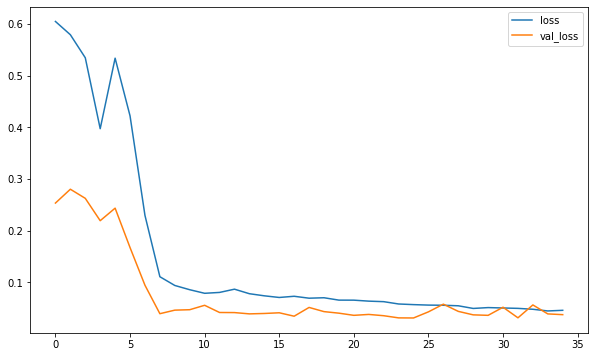

In [72]:
loss_df = pd.DataFrame(model.history.history)
loss_df.plot()

#### Evaluate on Test Data

In [73]:
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

In [74]:
def eval_metrics(actual, pred):
    rmse = np.sqrt(mean_squared_error(actual, pred))
    mae = mean_absolute_error(actual, pred)
    mse = mean_squared_error(actual, pred)
    score = r2_score(actual, pred)
    return print("r2_score:", score, "\n","mae:", mae, "\n","mse:",mse, "\n","rmse:",rmse)

In [75]:
y_pred = model.predict(validation_generator)
y_pred

48/48 [==============================] - 0s 2ms/step


array([[-0.77887434],
       [-0.98257107],
       [-1.0822711 ],
       [-0.90725344],
       [-0.15980843],
       [ 0.12385789],
       [ 0.47792542],
       [ 0.7396238 ],
       [ 0.668337  ],
       [ 0.62212247],
       [ 0.20515957],
       [-0.06999069],
       [-0.5082024 ],
       [-0.6782913 ],
       [-0.98131853],
       [-0.6608866 ],
       [-0.05117619],
       [ 0.36263385],
       [ 0.5330298 ],
       [ 0.6823888 ],
       [ 0.40490246],
       [ 0.33589542],
       [-0.09875345],
       [-0.3270113 ],
       [-0.77820975],
       [-0.94204897],
       [-1.1302683 ],
       [-0.754216  ],
       [-0.39805436],
       [ 0.01028836],
       [ 0.2163293 ],
       [ 0.36640692],
       [ 0.33180684],
       [ 0.41142958],
       [ 0.04411572],
       [-0.30766666],
       [-0.6554264 ],
       [-0.9343911 ],
       [-1.0026257 ],
       [-0.71360046],
       [-0.21306676],
       [ 0.06237827],
       [ 0.4566402 ],
       [ 0.5414016 ],
       [ 0.47762364],
       [ 0

In [76]:
test_scaled[24:]

array([[-0.57827993],
       [-0.85486805],
       [-1.15961655],
       [-0.61671847],
       [-0.30255233],
       [ 0.18444325],
       [ 0.45978345],
       [ 0.36834622],
       [ 0.76065107],
       [ 0.48175225],
       [ 0.36109871],
       [-0.09474012],
       [-0.32280353],
       [-0.82741734],
       [-1.01281507],
       [-0.56752523],
       [ 0.0544612 ],
       [ 0.30508308],
       [ 0.42610345],
       [ 0.18047323],
       [ 0.42126264],
       [ 0.18734363],
       [ 0.08133252],
       [-0.44180461],
       [-0.69684904],
       [-1.14374677],
       [-1.19949156],
       [-0.93816641],
       [-0.38772599],
       [-0.11944816],
       [ 0.05593539],
       [-0.01525408],
       [ 0.4725883 ],
       [ 0.2201734 ],
       [ 0.06440338],
       [-0.25669829],
       [-0.63997632],
       [-0.97243609],
       [-1.16695662],
       [-0.81596326],
       [-0.43497878],
       [ 0.18418613],
       [ 0.14299463],
       [ 0.12897272],
       [ 0.48549257],
       [-0

In [77]:
eval_metrics(test_scaled[24:], y_pred)

r2_score: 0.8688023988924365 
 mae: 0.15058788321221347 
 mse: 0.037188867907068976 
 rmse: 0.19284415445397607


In [78]:
test_predictions = []

first_eval_batch = train_scaled[-length:]

current_batch = first_eval_batch.reshape((1, length, n_features))

for i in range(len(test)):
    
    # get prediction 1 time stamp ahead
    current_pred = model.predict(current_batch)[0]
    
    # store prediction
    test_predictions.append(current_pred) 
    
    # update batch to now include prediction and drop first value
    current_batch = np.append(current_batch[:, 1:, :], [[current_pred]], axis=1)

1/1 [==============================] - 0s 16ms/step


In [79]:
eval_metrics(test_scaled, test_predictions)

r2_score: 0.7471647635629448 
 mae: 0.22320316388942507 
 mse: 0.07162447433739835 
 rmse: 0.267627491744399


#### Inverse Transformations and Comparing

In [80]:
true_predictions_relu = scaler.inverse_transform(test_predictions)

In [81]:
test['predictions_relu'] = true_predictions_relu

In [82]:
test.head(2)

,amount,prediction,predictions_relu
DATE,,,
2013-10-01,90.998,85.921,85.152
2013-11-01,80.069,76.881,75.376


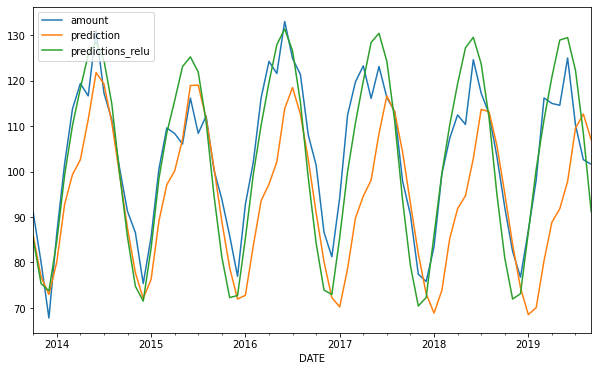

In [83]:
test.plot();

#### Calculation R2 Score and Error Metrics

In [84]:
eval_metrics(test.amount, test.predictions_relu)

r2_score: 0.7471647523340701 
 mae: 6.510533564758301 
 mse: 60.93880130126907 
 rmse: 7.806330847540929


## 7. Retrain and Forecasting

In [85]:
test

,amount,prediction,predictions_relu
DATE,,,
2013-10-01,90.998,85.921,85.152
2013-11-01,80.069,76.881,75.376
2013-12-01,67.803,72.961,73.763
2014-01-01,86.397,80.117,84.673
2014-02-01,101.731,92.794,99.241
2014-03-01,113.776,99.329,110.151
2014-04-01,119.353,102.597,118.231
2014-05-01,116.631,111.428,125.670
2014-06-01,131.040,121.749,128.435


In [86]:
full_scaler = StandardScaler()
scaled_full_data = full_scaler.fit_transform(df)

In [87]:
length = 24 
generator = TimeseriesGenerator(scaled_full_data, scaled_full_data, length = length, batch_size = 1)

In [88]:
model = Sequential()

model.add(LSTM(55, activation = 'tanh', input_shape = (length, n_features)))
model.add(Dense(1))
model.compile(optimizer = 'adam', loss = 'mse')

model.fit_generator(generator, epochs=64)

Epoch 1/64
549/549 [==============================] - 6s 9ms/step - loss: 0.3567
Epoch 2/64
549/549 [==============================] - 5s 8ms/step - loss: 0.0715
Epoch 3/64
549/549 [==============================] - 5s 8ms/step - loss: 0.0619
Epoch 4/64
549/549 [==============================] - 5s 8ms/step - loss: 0.0585
Epoch 5/64
549/549 [==============================] - 5s 9ms/step - loss: 0.0557
Epoch 6/64
549/549 [==============================] - 5s 8ms/step - loss: 0.0523
Epoch 7/64
549/549 [==============================] - 5s 8ms/step - loss: 0.0474
Epoch 8/64
549/549 [==============================] - 5s 9ms/step - loss: 0.0450
Epoch 9/64
549/549 [==============================] - 5s 9ms/step - loss: 0.0466
Epoch 10/64
549/549 [==============================] - 5s 9ms/step - loss: 0.0446
Epoch 11/64
549/549 [==============================] - 5s 9ms/step - loss: 0.0428
Epoch 12/64
549/549 [==============================] - 5s 9ms/step - loss: 0.0462
Epoch 13/64
549/549 [====

In [89]:
scaled_full_data.shape

(573, 1)

In [90]:
scaled_full_data[-length:].shape

(24, 1)

In [91]:
forecast = []
# Replace periods with whatever forecast length you want
periods = 24

first_eval_batch = scaled_full_data[-length:] 
current_batch = first_eval_batch.reshape((1, length, n_features))

for i in range(periods):
    
    # get prediction 1 time stamp ahead ([0] is for grabbing just the number instead of [array])
    current_pred = model.predict(current_batch)[0]
    
    # store prediction
    forecast.append(current_pred) 
    
    # update batch to now include prediction and drop first value
    current_batch = np.append(current_batch[:, 1:, :], [[current_pred]], axis = 1)

1/1 [==============================] - 0s 24ms/step


In [92]:
forecast = scaler.inverse_transform(forecast)

In [93]:
forecast

array([[ 90.973335],
       [ 80.49501 ],
       [ 72.956375],
       [ 80.87377 ],
       [ 94.73379 ],
       [108.08716 ],
       [114.61876 ],
       [112.68385 ],
       [117.47978 ],
       [115.460556],
       [108.35659 ],
       [ 98.04934 ],
       [ 88.05183 ],
       [ 77.48642 ],
       [ 69.53797 ],
       [ 76.69231 ],
       [ 89.89917 ],
       [103.329445],
       [110.157486],
       [108.76079 ],
       [116.96557 ],
       [112.22188 ],
       [106.825294],
       [ 95.04639 ]], dtype=float32)

In [94]:
df.head()

,amount
DATE,
1972-01-01,59.962
1972-02-01,67.061
1972-03-01,74.235
1972-04-01,78.112
1972-05-01,84.764


In [95]:
forecast_index = pd.date_range(start = '2019-10-01', periods = periods, freq = 'MS')

In [96]:
forecast_index

DatetimeIndex(['2019-10-01', '2019-11-01', '2019-12-01', '2020-01-01',
               '2020-02-01', '2020-03-01', '2020-04-01', '2020-05-01',
               '2020-06-01', '2020-07-01', '2020-08-01', '2020-09-01',
               '2020-10-01', '2020-11-01', '2020-12-01', '2021-01-01',
               '2021-02-01', '2021-03-01', '2021-04-01', '2021-05-01',
               '2021-06-01', '2021-07-01', '2021-08-01', '2021-09-01'],
              dtype='datetime64[ns]', freq='MS')

In [97]:
forecast_df = pd.DataFrame(data = forecast, index = forecast_index, columns = ['forecast'])

In [98]:
forecast_df

,forecast
2019-10-01,90.973
2019-11-01,80.495
2019-12-01,72.956
2020-01-01,80.874
2020-02-01,94.734
2020-03-01,108.087
2020-04-01,114.619
2020-05-01,112.684
2020-06-01,117.480
2020-07-01,115.461


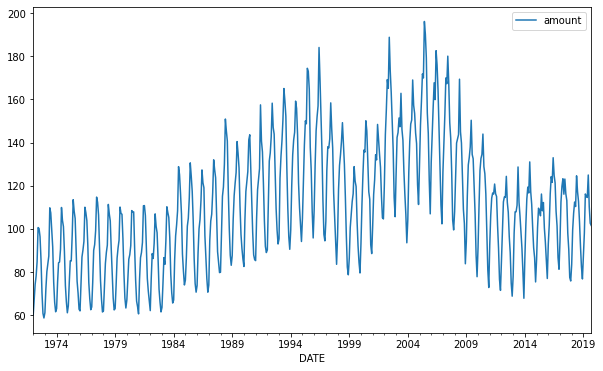

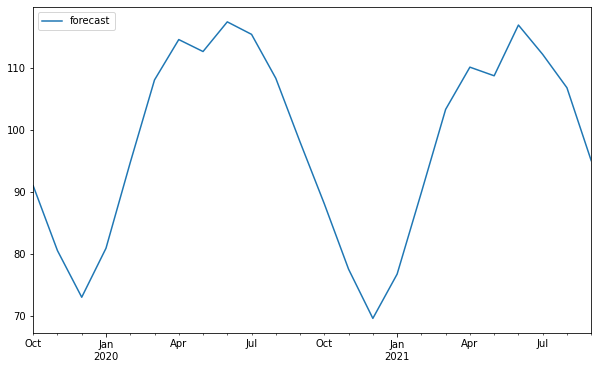

In [99]:
df.plot();
forecast_df.plot();

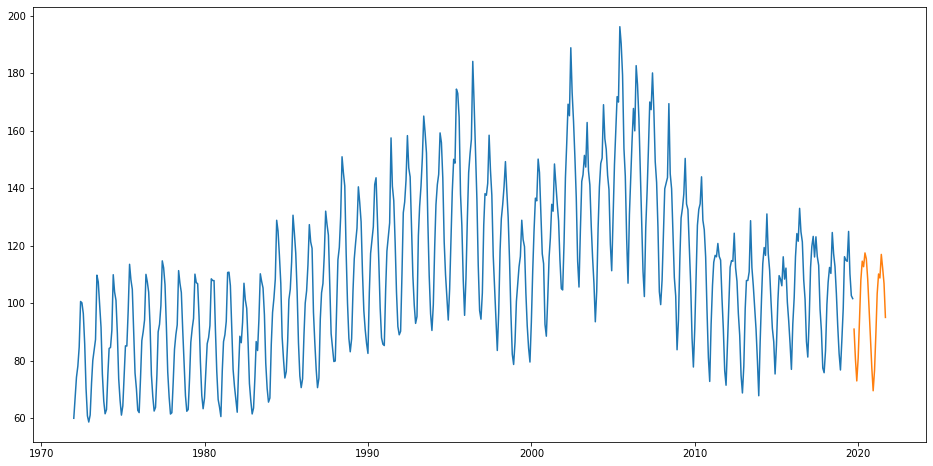

In [100]:
plt.figure(figsize = (16, 8))
plt.plot(df.index, df['amount'])
plt.plot(forecast_df.index, forecast_df['forecast']);
#plt.plot(forecast_index, forecast)

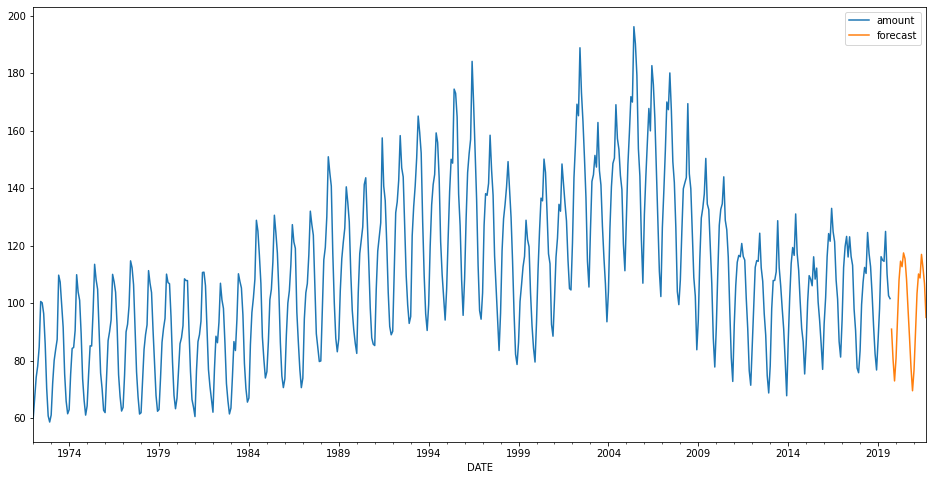

In [101]:
ax = df.plot()
forecast_df.plot(ax = ax, figsize = (16, 8));

## Appx. Another approach: With actual human consuming behaviours in last 10 years

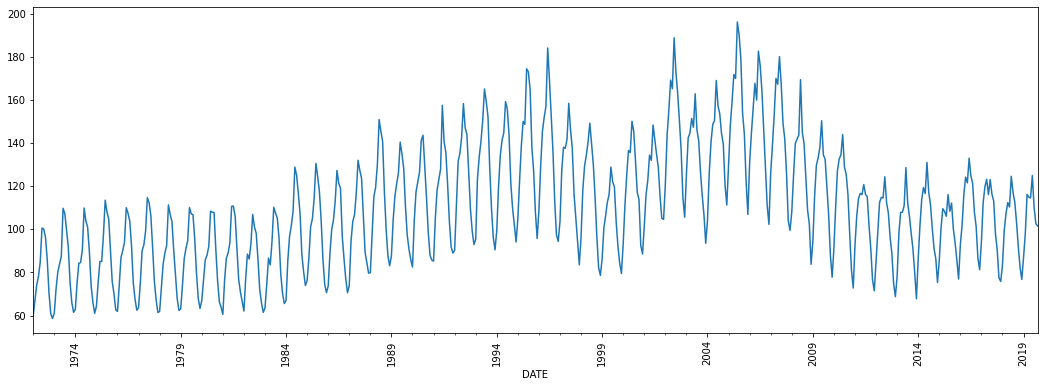

In [102]:
df['amount'].plot(figsize=(18,6))
plt.xticks(rotation=90);

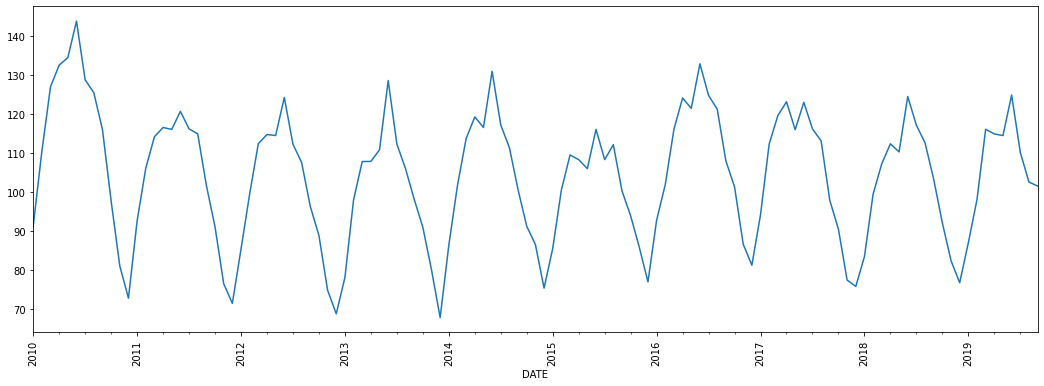

In [103]:
df['amount'].loc["2010-01-01" : "2019-09-01"].plot(figsize=(18,6))
plt.xticks(rotation=90);

In [104]:
df = df.loc["2010-01-01" : "2019-09-01"]
df.head()

,amount
DATE,
2010-01-01,91.290
2010-02-01,110.499
2010-03-01,127.097
2010-04-01,132.647
2010-05-01,134.558


### Preprocessing of Data

### Train Test Split

In [105]:
len(df)

117

In [106]:
test_size = 36

In [107]:
test_ind = len(df)- test_size
test_ind

81

In [108]:
train = df.iloc[:test_ind]
test = df.iloc[test_ind:]

In [109]:
train.head()

,amount
DATE,
2010-01-01,91.290
2010-02-01,110.499
2010-03-01,127.097
2010-04-01,132.647
2010-05-01,134.558


In [110]:
test.head()

,amount
DATE,
2016-10-01,101.384
2016-11-01,86.665
2016-12-01,81.257
2017-01-01,94.245
2017-02-01,112.388


### Scaling

In [111]:
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
train_scaled = scaler.fit_transform(train)
test_scaled = scaler.transform(test)

## Time Series Generator

In [112]:
from tensorflow.keras.preprocessing.sequence import TimeseriesGenerator

In [113]:
# help(TimeseriesGenerator)

In [114]:
length = 12
generator = TimeseriesGenerator(train_scaled, train_scaled, length = length, batch_size = 1)

In [115]:
generator[0]

(array([[[-0.77649658],
         [ 0.32921347],
         [ 1.28456688],
         [ 1.60400421],
         [ 1.71398868],
         [ 2.25471882],
         [ 1.38584262],
         [ 1.19587938],
         [ 0.6497732 ],
         [-0.40451905],
         [-1.36374046],
         [-1.84188628]]]),
 array([[-0.70043185]]))

In [116]:
train_scaled[0:13]

array([[-0.77649658],
       [ 0.32921347],
       [ 1.28456688],
       [ 1.60400421],
       [ 1.71398868],
       [ 2.25471882],
       [ 1.38584262],
       [ 1.19587938],
       [ 0.6497732 ],
       [-0.40451905],
       [-1.36374046],
       [-1.84188628],
       [-0.70043185]])

In [117]:
X_act, y_act= generator[0]

In [118]:
print(f'Given the Array: \n{X_act.flatten()}')
print(f'Predict this y: \n {y_act}')

Given the Array: 
[-0.77649658  0.32921347  1.28456688  1.60400421  1.71398868  2.25471882
  1.38584262  1.19587938  0.6497732  -0.40451905 -1.36374046 -1.84188628]
Predict this y: 
 [[-0.70043185]]


## Modelling & Model Performance

### Creating Model

In [122]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, LSTM
n_features = 1
model = Sequential()
model.add(LSTM(57, activation = 'tanh', input_shape = (length, n_features)))
model.add(Dense(1)) 
model.compile(optimizer = 'adam', loss = 'mse')
model.summary()

Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_4 (LSTM)               (None, 57)                13452     
                                                                 
 dense_4 (Dense)             (None, 1)                 58        
                                                                 
Total params: 13,510
Trainable params: 13,510
Non-trainable params: 0
_________________________________________________________________


### EarlyStopping and Validation Generator

In [123]:
from tensorflow.keras.callbacks import EarlyStopping
early_stop = EarlyStopping(monitor = 'val_loss', patience = 10)
validation_generator = TimeseriesGenerator(test_scaled, test_scaled, length = length, batch_size = 1)
model.fit_generator(generator, epochs = 50,
                    validation_data = validation_generator,
                    callbacks = [early_stop])

Epoch 1/50
69/69 [==============================] - 3s 14ms/step - loss: 0.5437 - val_loss: 0.1845
Epoch 2/50
69/69 [==============================] - 0s 7ms/step - loss: 0.1761 - val_loss: 0.1086
Epoch 3/50
69/69 [==============================] - 0s 7ms/step - loss: 0.1180 - val_loss: 0.0801
Epoch 4/50
69/69 [==============================] - 0s 6ms/step - loss: 0.0974 - val_loss: 0.1077
Epoch 5/50
69/69 [==============================] - 0s 6ms/step - loss: 0.0989 - val_loss: 0.0926
Epoch 6/50
69/69 [==============================] - 0s 6ms/step - loss: 0.0995 - val_loss: 0.1128
Epoch 7/50
69/69 [==============================] - 0s 7ms/step - loss: 0.0941 - val_loss: 0.1106
Epoch 8/50
69/69 [==============================] - 0s 7ms/step - loss: 0.1071 - val_loss: 0.0881
Epoch 9/50
69/69 [==============================] - 0s 7ms/step - loss: 0.0956 - val_loss: 0.1025
Epoch 10/50
69/69 [==============================] - 0s 6ms/step - loss: 0.0877 - val_loss: 0.0914
Epoch 11/50
69/69 

<AxesSubplot:>

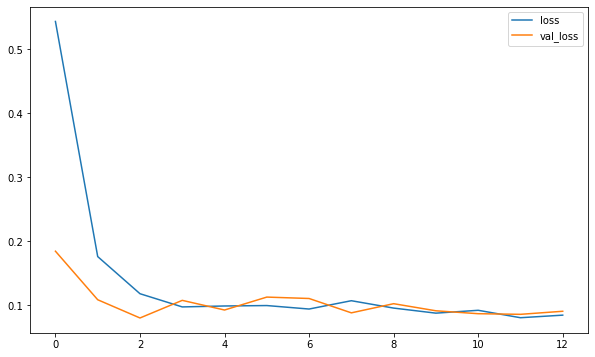

In [124]:
loss_df = pd.DataFrame(model.history.history)
loss_df.plot()

#### Evaluate on Test Data

In [125]:
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
def eval_metrics(actual, pred):
    rmse = np.sqrt(mean_squared_error(actual, pred))
    mae = mean_absolute_error(actual, pred)
    mse = mean_squared_error(actual, pred)
    score = r2_score(actual, pred)
    return print("r2_score:", score, "\n","mae:", mae, "\n","mse:",mse, "\n","rmse:",rmse)
y_pred = model.predict(validation_generator)
eval_metrics(test_scaled[12:], y_pred)

24/24 [==============================] - 0s 3ms/step
r2_score: 0.8764356974752998 
 mae: 0.24700344147584144 
 mse: 0.09060259141966258 
 rmse: 0.3010026435426483


In [126]:
test_predictions = []

first_eval_batch = train_scaled[-length:]

current_batch = first_eval_batch.reshape((1, length, n_features))

for i in range(len(test)):
    
    # get prediction 1 time stamp ahead
    current_pred = model.predict(current_batch)[0]
    
    # store prediction
    test_predictions.append(current_pred) 
    
    # update batch to now include prediction and drop first value
    current_batch = np.append(current_batch[:, 1:, :], [[current_pred]], axis=1)
    
eval_metrics(test_scaled, test_predictions)

1/1 [==============================] - 0s 16ms/step
r2_score: 0.8381205356056151 
 mae: 0.27296798514161025 
 mse: 0.11671950397284757 
 rmse: 0.34164236267308473


#### Inverse Transformations and Comparing

In [127]:
true_predictions = scaler.inverse_transform(test_predictions)

In [128]:
test.head()

,amount
DATE,
2016-10-01,101.384
2016-11-01,86.665
2016-12-01,81.257
2017-01-01,94.245
2017-02-01,112.388


In [129]:
test['prediction'] = true_predictions

In [130]:
test

,amount,prediction
DATE,,
2016-10-01,101.384,95.346
2016-11-01,86.665,82.450
2016-12-01,81.257,73.246
2017-01-01,94.245,88.082
2017-02-01,112.388,100.905
2017-03-01,119.698,109.175
2017-04-01,123.228,114.513
2017-05-01,116.064,118.650
2017-06-01,123.087,121.871


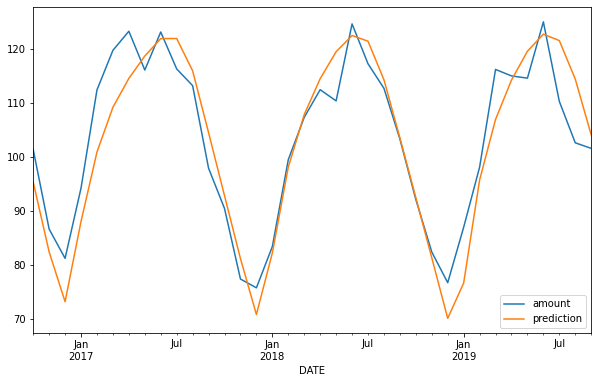

In [131]:
test.plot();

#### Calculation R2 Score and Error Metrics

In [132]:
eval_metrics(test.amount, test.prediction)

r2_score: 0.8381205442240579 
 mae: 4.742371220906576 
 mse: 35.22987540271468 
 rmse: 5.93547600472908


## Retrain and Forecasting

In [133]:
test

,amount,prediction
DATE,,
2016-10-01,101.384,95.346
2016-11-01,86.665,82.450
2016-12-01,81.257,73.246
2017-01-01,94.245,88.082
2017-02-01,112.388,100.905
2017-03-01,119.698,109.175
2017-04-01,123.228,114.513
2017-05-01,116.064,118.650
2017-06-01,123.087,121.871


In [134]:
full_scaler = StandardScaler()
scaled_full_data = full_scaler.fit_transform(df)

In [135]:
length = 12
generator = TimeseriesGenerator(scaled_full_data, scaled_full_data, length = length, batch_size = 1)

In [150]:
model = Sequential()

model.add(LSTM(57, activation = 'tanh', input_shape = (length, n_features)))
model.add(Dense(1))
model.compile(optimizer = 'adam', loss = 'mse')

model.fit_generator(generator, epochs=64)

Epoch 1/64
105/105 [==============================] - 3s 7ms/step - loss: 0.4275
Epoch 2/64
105/105 [==============================] - 1s 5ms/step - loss: 0.1697
Epoch 3/64
105/105 [==============================] - 1s 5ms/step - loss: 0.1058
Epoch 4/64
105/105 [==============================] - 1s 5ms/step - loss: 0.1104
Epoch 5/64
105/105 [==============================] - 1s 6ms/step - loss: 0.1116
Epoch 6/64
105/105 [==============================] - 1s 5ms/step - loss: 0.0976
Epoch 7/64
105/105 [==============================] - 1s 5ms/step - loss: 0.1142
Epoch 8/64
105/105 [==============================] - 1s 5ms/step - loss: 0.1019
Epoch 9/64
105/105 [==============================] - 1s 5ms/step - loss: 0.0988
Epoch 10/64
105/105 [==============================] - 1s 6ms/step - loss: 0.0916
Epoch 11/64
105/105 [==============================] - 1s 6ms/step - loss: 0.0922
Epoch 12/64
105/105 [==============================] - 1s 5ms/step - loss: 0.0962
Epoch 13/64
105/105 [====

In [151]:
scaled_full_data.shape

(117, 1)

In [152]:
scaled_full_data[-length:].shape

(12, 1)

In [153]:
forecast = []
# Replace periods with whatever forecast length you want
periods = 12

first_eval_batch = scaled_full_data[-length:] 
current_batch = first_eval_batch.reshape((1, length, n_features))

for i in range(periods):
    
    # get prediction 1 time stamp ahead ([0] is for grabbing just the number instead of [array])
    current_pred = model.predict(current_batch)[0]
    
    # store prediction
    forecast.append(current_pred) 
    
    # update batch to now include prediction and drop first value
    current_batch = np.append(current_batch[:, 1:, :], [[current_pred]], axis = 1)

1/1 [==============================] - 0s 16ms/step


In [154]:
forecast = scaler.inverse_transform(forecast)

In [155]:
forecast

array([[ 90.41806 ],
       [ 79.473366],
       [ 75.42434 ],
       [ 88.59626 ],
       [101.443665],
       [113.524895],
       [116.7968  ],
       [123.3216  ],
       [127.03812 ],
       [122.51857 ],
       [117.0572  ],
       [108.393524]], dtype=float32)

In [156]:
df.head()

,amount
DATE,
2010-01-01,91.290
2010-02-01,110.499
2010-03-01,127.097
2010-04-01,132.647
2010-05-01,134.558


In [157]:
forecast_index = pd.date_range(start = '2019-10-01', periods = periods, freq = 'MS')

In [158]:
forecast_index

DatetimeIndex(['2019-10-01', '2019-11-01', '2019-12-01', '2020-01-01',
               '2020-02-01', '2020-03-01', '2020-04-01', '2020-05-01',
               '2020-06-01', '2020-07-01', '2020-08-01', '2020-09-01'],
              dtype='datetime64[ns]', freq='MS')

In [159]:
forecast_df = pd.DataFrame(data = forecast, index = forecast_index, columns = ['forecast'])

In [160]:
forecast_df

,forecast
2019-10-01,90.418
2019-11-01,79.473
2019-12-01,75.424
2020-01-01,88.596
2020-02-01,101.444
2020-03-01,113.525
2020-04-01,116.797
2020-05-01,123.322
2020-06-01,127.038
2020-07-01,122.519


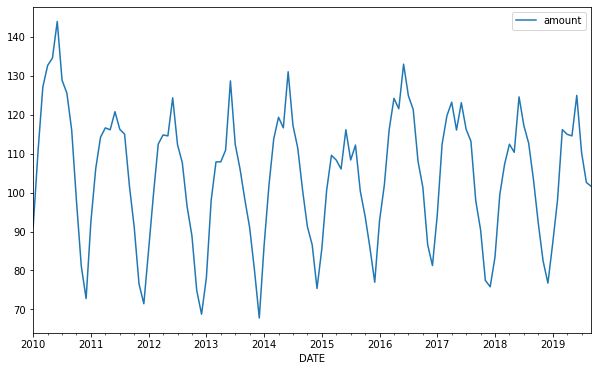

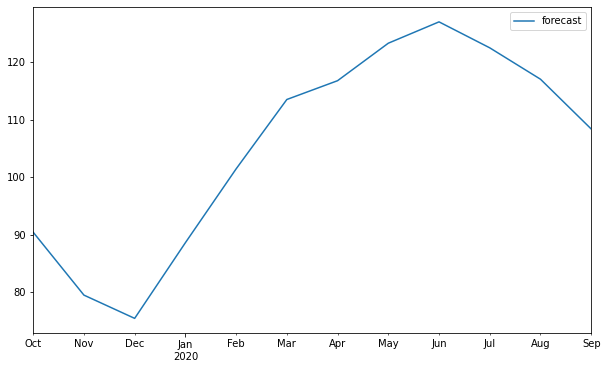

In [161]:
df.plot();
forecast_df.plot();

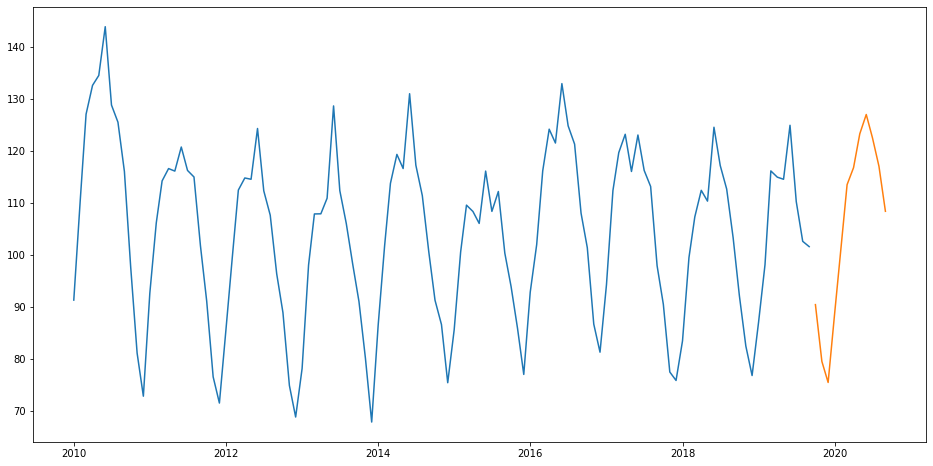

In [162]:
plt.figure(figsize = (16, 8))
plt.plot(df.index, df['amount'])
plt.plot(forecast_df.index, forecast_df['forecast']);
#plt.plot(forecast_index, forecast)

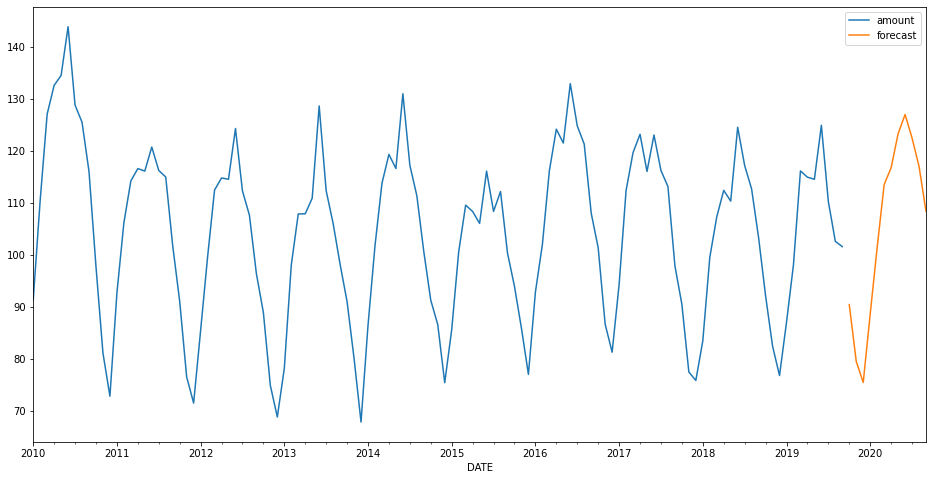

In [163]:
ax = df.plot()
forecast_df.plot(ax = ax, figsize = (16, 8));